In [1]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import Callable, Iterable, Iterator, TypeVar, Sequence, Tuple, Generic, Optional, Mapping
import numpy as np
from src.returns import plot_progress_

S = TypeVar('S')
X = TypeVar('X')
A = TypeVar('A')

class State(ABC, Generic[S]):
    state: S
    pass

@dataclass(frozen=True)
class ReturnStep():
    pass

@dataclass(frozen=True)
class NonTerminal(State[S]):
    state: S
        
    def __eq__(self, other):
        return self.state == other.state

    def __lt__(self, other):
        return self.state < other.state

class State(ABC, Generic[S]):
    state: S

    def on_non_terminal(
        self,
        f: Callable[[NonTerminal[S]], X],
        default: X
    ) -> X:
        if isinstance(self, NonTerminal):
            return f(self)
        else:
            return default

@dataclass(frozen=True)
class TransitionStep(Generic[S, A]):
    '''A single step in the simulation of an MDP, containing:

    state -- the state we start from
    action -- the action we took at that state
    next_state -- the state we ended up in after the action
    reward -- the instantaneous reward we got for this transition
    '''
    state: NonTerminal[S]
    action: A
    next_state: State[S]
    reward: float

    def add_return(self, γ: float, return_: float) -> ReturnStep:
        '''Given a γ and the return from 'next_state', this annotates the
        transition with a return for 'state'.

        '''
        return ReturnStep(
            self.state,
            self.action,
            self.next_state,
            self.reward,
            return_=self.reward + γ * return_
        )

@dataclass(frozen=True)
class ReturnStep(TransitionStep[S, A]):
    '''A Transition that also contains the total *return* for its starting
    state.

    '''
    return_: float


In [2]:
F = TypeVar('F', bound='FunctionApprox')

@dataclass(frozen=True)
class Gradient(Generic[F]):
    pass

class FunctionApprox(ABC, Generic[X]):
    '''Interface for function approximations.
    An object of this class approximates some function X ↦ ℝ in a way
    that can be evaluated at specific points in X and updated with
    additional (X, ℝ) points.
    '''

    @abstractmethod
    def __add__(self: F, other: F) -> F:
        pass

    @abstractmethod
    def __mul__(self: F, scalar: float) -> F:
        pass

    @abstractmethod
    def objective_gradient(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], np.ndarray]
    ) -> Gradient[F]:
        '''Computes the gradient of an objective function of the self
        FunctionApprox with respect to the parameters in the internal
        representation of the FunctionApprox. The gradient is output
        in the form of a Gradient[FunctionApprox] whose internal parameters are
        equal to the gradient values. The argument `obj_deriv_out_fun'
        represents the derivative of the objective with respect to the output
        (evaluate) of the FunctionApprox, when evaluated at a Sequence of
        x values and a Sequence of y values (to be obtained from 'xy_vals_seq')
        '''

    @abstractmethod
    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        '''Computes expected value of y for each x in
        x_values_seq (with the probability distribution
        function of y|x estimated as FunctionApprox)
        '''

    def __call__(self, x_value: X) -> float:
        return self.evaluate([x_value]).item()

    @abstractmethod
    def update_with_gradient(
        self: F,
        gradient: Gradient[F]
    ) -> F:
        '''Update the internal parameters of self FunctionApprox using the
        input gradient that is presented as a Gradient[FunctionApprox]
        '''

    def update(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> F:

        '''Update the internal parameters of the FunctionApprox
        based on incremental data provided in the form of (x,y)
        pairs as a xy_vals_seq data structure
        '''
        def deriv_func(x: Sequence[X], y: Sequence[float]) -> np.ndarray:
            return self.evaluate(x) - np.array(y)

        return self.update_with_gradient(
            self.objective_gradient(xy_vals_seq, deriv_func)
        )

    @abstractmethod
    def solve(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> F:
        '''Assuming the entire data set of (x,y) pairs is available
        in the form of the given input xy_vals_seq data structure,
        solve for the internal parameters of the FunctionApprox
        such that the internal parameters are fitted to xy_vals_seq.
        Since this is a best-fit, the internal parameters are fitted
        to within the input error_tolerance (where applicable, since
        some methods involve a direct solve for the fit that don't
        require an error_tolerance)
        '''

    @abstractmethod
    def within(self: F, other: F, tolerance: float) -> bool:
        '''Is this function approximation within a given tolerance of
        another function approximation of the same type?
        '''

    def iterate_updates(
        self: F,
        xy_seq_stream: Iterator[Iterable[Tuple[X, float]]]
    ) -> Iterator[F]:
        '''Given a stream (Iterator) of data sets of (x,y) pairs,
        perform a series of incremental updates to the internal
        parameters (using update method), with each internal
        parameter update done for each data set of (x,y) pairs in the
        input stream of xy_seq_stream
        '''
        return iterate.accumulate(
            xy_seq_stream,
            lambda fa, xy: fa.update(xy),
            initial=self
        )

    def rmse(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> float:
        '''The Root-Mean-Squared-Error between FunctionApprox's
        predictions (from evaluate) and the associated (supervisory)
        y values
        '''
        x_seq, y_seq = zip(*xy_vals_seq)
        errors: np.ndarray = self.evaluate(x_seq) - np.array(y_seq)
        return np.sqrt(np.mean(errors * errors))

    def argmax(self, xs: Iterable[X]) -> X:
        '''Return the input X that maximizes the function being approximated.
        Arguments:
          xs -- list of inputs to evaluate and maximize, cannot be empty
        Returns the X that maximizes the function this approximates.
        '''
        args: Sequence[X] = list(xs)
        return args[np.argmax(self.evaluate(args))]

@dataclass(frozen=True)
class Gradient(Generic[F]):
    function_approx: F

    # @overload
    # def __add__(self, x: Gradient[F]) -> Gradient[F]:
    #     ...

    # @overload
    # def __add__(self, x: F) -> F:
    #     ...

    def __add__(self, x):
        if isinstance(x, Gradient):
            return Gradient(self.function_approx + x.function_approx)

        return self.function_approx + x

    def __mul__(self: Gradient[F], x: float) -> Gradient[F]:
        return Gradient(self.function_approx * x)

    def zero(self) -> Gradient[F]:
        return Gradient(self.function_approx * 0.0)

In [3]:
B = TypeVar('B')

class Distribution(ABC, Generic[A]):
    pass

class FiniteDistribution(Distribution[A], ABC):
    pass

class Distribution(ABC, Generic[A]):
    '''A probability distribution that we can sample.

    '''
    @abstractmethod
    def sample(self) -> A:
        '''Return a random sample from this distribution.

        '''
        pass

    def sample_n(self, n: int) -> Sequence[A]:
        '''Return n samples from this distribution.'''
        return [self.sample() for _ in range(n)]

    @abstractmethod
    def expectation(
        self,
        f: Callable[[A], float]
    ) -> float:
        '''Return the expecation of f(X) where X is the
        random variable for the distribution and f is an
        arbitrary function from X to float

        '''
        pass

    def map(
        self,
        f: Callable[[A], B]
    ) -> Distribution[B]:
        '''Apply a function to the outcomes of this distribution.'''
        return SampledDistribution(lambda: f(self.sample()))

    def apply(
        self,
        f: Callable[[A], Distribution[B]]
    ) -> Distribution[B]:
        '''Apply a function that returns a distribution to the outcomes of
        this distribution. This lets us express *dependent random
        variables*.

        '''
        def sample():
            a = self.sample()
            b_dist = f(a)
            return b_dist.sample()

        return SampledDistribution(sample)

class FiniteDistribution(Distribution[A], ABC):
    '''A probability distribution with a finite number of outcomes, which
    means we can render it as a PDF or CDF table.

    '''
    @abstractmethod
    def table(self) -> Mapping[A, float]:
        '''Returns a tabular representation of the probability density
        function (PDF) for this distribution.

        '''
        pass

    def probability(self, outcome: A) -> float:
        '''Returns the probability of the given outcome according to this
        distribution.

        '''
        return self.table()[outcome]

    def map(self, f: Callable[[A], B]) -> FiniteDistribution[B]:
        '''Return a new distribution that is the result of applying a function
        to each element of this distribution.

        '''
        result: Dict[B, float] = defaultdict(float)

        for x, p in self:
            result[f(x)] += p

        return Categorical(result)

    def sample(self) -> A:
        outcomes = list(self.table().keys())
        weights = list(self.table().values())
        return random.choices(outcomes, weights=weights)[0]

    # TODO: Can we get rid of f or make it optional? Right now, I
    # don't think that's possible with mypy.
    def expectation(self, f: Callable[[A], float]) -> float:
        '''Calculate the expected value of the distribution, using the given
        function to turn the outcomes into numbers.

        '''
        return sum(p * f(x) for x, p in self)

    def __iter__(self) -> Iterator[Tuple[A, float]]:
        return iter(self.table().items())

    def __eq__(self, other: object) -> bool:
        if isinstance(other, FiniteDistribution):
            return self.table() == other.table()
        else:
            return False

    def __repr__(self) -> str:
        return repr(self.table())

@dataclass(frozen=True)
class Constant(FiniteDistribution[A]):
    '''A distribution that has a single outcome with probability 1.

    '''
    value: A

    def sample(self) -> A:
        return self.value

    def table(self) -> Mapping[A, float]:
        return {self.value: 1}

    def probability(self, outcome: A) -> float:
        return 1. if outcome == self.value else 0.

In [4]:
class Policy(ABC, Generic[S, A]):
    '''A policy is a function that specifies what we should do (the
    action) at a given state of our MDP.

    '''
    @abstractmethod
    def act(self, state: NonTerminal[S]) -> Distribution[A]:
        '''A distribution of actions to take from the given non-terminal
        state.
        '''

@dataclass(frozen=True)
class DeterministicPolicy(Policy[S, A]):
    action_for: Callable[[S], A]

    def act(self, state: NonTerminal[S]) -> Constant[A]:
        return Constant(self.action_for(state.state))

In [5]:
# A representation of a value function for a finite MDP with states of
# type S
ValueFunctionApprox = FunctionApprox[NonTerminal[S]]
QValueFunctionApprox = FunctionApprox[Tuple[NonTerminal[S], A]]

def greedy_policy_from_qvf(
    q: QValueFunctionApprox[S, A],
    actions: Callable[[NonTerminal[S]], Iterable[A]]
) -> DeterministicPolicy[S, A]:
    '''Return the policy that takes the optimal action at each state based
    on the given approximation of the process's Q function.

    '''
    def optimal_action(s: S) -> A:
        _, a = q.argmax((NonTerminal(s), a) for a in actions(NonTerminal(s)))
        return a
    return DeterministicPolicy(optimal_action)

In [6]:
# from src.function_approx import LinearFunctionApprox, Weights

class AdamGradient:
    pass

class Weights:
    pass

class LinearFunctionApprox(FunctionApprox[X]):
    pass

@dataclass(frozen=True)
class AdamGradient:
    learning_rate: float
    decay1: float
    decay2: float

    @staticmethod
    def default_settings() -> AdamGradient:
        return AdamGradient(
            learning_rate=0.001,
            decay1=0.9,
            decay2=0.999
        )


@dataclass(frozen=True)
class Weights:
    adam_gradient: AdamGradient
    time: int
    weights: np.ndarray
    adam_cache1: np.ndarray
    adam_cache2: np.ndarray

    @staticmethod
    def create(
        weights: np.ndarray,
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        adam_cache1: Optional[np.ndarray] = None,
        adam_cache2: Optional[np.ndarray] = None
    ) -> Weights:
        return Weights(
            adam_gradient=adam_gradient,
            time=0,
            weights=weights,
            adam_cache1=np.zeros_like(
                weights
            ) if adam_cache1 is None else adam_cache1,
            adam_cache2=np.zeros_like(
                weights
            ) if adam_cache2 is None else adam_cache2
        )

    def update(self, gradient: np.ndarray) -> Weights:
        time: int = self.time + 1
        new_adam_cache1: np.ndarray = self.adam_gradient.decay1 * \
            self.adam_cache1 + (1 - self.adam_gradient.decay1) * gradient
        new_adam_cache2: np.ndarray = self.adam_gradient.decay2 * \
            self.adam_cache2 + (1 - self.adam_gradient.decay2) * gradient ** 2
        corrected_m: np.ndarray = new_adam_cache1 / \
            (1 - self.adam_gradient.decay1 ** time)
        corrected_v: np.ndarray = new_adam_cache2 / \
            (1 - self.adam_gradient.decay2 ** time)

        new_weights: np.ndarray = self.weights - \
            self.adam_gradient.learning_rate * corrected_m / \
            (np.sqrt(corrected_v) + SMALL_NUM)

        return replace(
            self,
            time=time,
            weights=new_weights,
            adam_cache1=new_adam_cache1,
            adam_cache2=new_adam_cache2,
        )

    def within(self, other: Weights, tolerance: float) -> bool:
        return np.all(np.abs(self.weights - other.weights) <= tolerance).item()


@dataclass(frozen=True)
class LinearFunctionApprox(FunctionApprox[X]):

    feature_functions: Sequence[Callable[[X], float]]
    regularization_coeff: float
    weights: Weights
    direct_solve: bool

    @staticmethod
    def create(
        feature_functions: Sequence[Callable[[X], float]],
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        regularization_coeff: float = 0.,
        weights: Optional[Weights] = None,
        direct_solve: bool = True
    ) -> LinearFunctionApprox[X]:
        return LinearFunctionApprox(
            feature_functions=feature_functions,
            regularization_coeff=regularization_coeff,
            weights=Weights.create(
                adam_gradient=adam_gradient,
                weights=np.zeros(len(feature_functions))
            ) if weights is None else weights,
            direct_solve=direct_solve
        )

    def get_feature_values(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return np.array(
            [[f(x) for f in self.feature_functions] for x in x_values_seq]
        )

    def objective_gradient(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]
    ) -> Gradient[LinearFunctionApprox[X]]:
        x_vals, y_vals = zip(*xy_vals_seq)
        obj_deriv_out: np.ndarray = obj_deriv_out_fun(x_vals, y_vals)
        features: np.ndarray = self.get_feature_values(x_vals)
        gradient: np.ndarray = \
            features.T.dot(obj_deriv_out) / len(obj_deriv_out) \
            + self.regularization_coeff * self.weights.weights
        return Gradient(replace(
            self,
            weights=replace(
                self.weights,
                weights=gradient
            )
        ))

    def __add__(self, other: LinearFunctionApprox[X]) -> \
            LinearFunctionApprox[X]:
        return replace(
            self,
            weights=replace(
                self.weights,
                weights=self.weights.weights + other.weights.weights
            )
        )

    def __mul__(self, scalar: float) -> LinearFunctionApprox[X]:
        return replace(
            self,
            weights=replace(
                self.weights,
                weights=self.weights.weights * scalar
            )
        )

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return np.dot(
            self.get_feature_values(x_values_seq),
            self.weights.weights
        )

    def update_with_gradient(
        self,
        gradient: Gradient[LinearFunctionApprox[X]]
    ) -> LinearFunctionApprox[X]:
        return replace(
            self,
            weights=self.weights.update(
                gradient.function_approx.weights.weights
            )
        )

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> LinearFunctionApprox[X]:
        if self.direct_solve:
            x_vals, y_vals = zip(*xy_vals_seq)
            feature_vals: np.ndarray = self.get_feature_values(x_vals)
            feature_vals_T: np.ndarray = feature_vals.T
            left: np.ndarray = np.dot(feature_vals_T, feature_vals) \
                + feature_vals.shape[0] * self.regularization_coeff * \
                np.eye(len(self.weights.weights))
            right: np.ndarray = np.dot(feature_vals_T, y_vals)
            ret = replace(
                self,
                weights=Weights.create(
                    adam_gradient=self.weights.adam_gradient,
                    weights=np.linalg.solve(left, right)
                )
            )
        else:
            tol: float = 1e-6 if error_tolerance is None else error_tolerance

            def done(
                a: LinearFunctionApprox[X],
                b: LinearFunctionApprox[X],
                tol: float = tol
            ) -> bool:
                return a.within(b, tol)

            ret = iterate.converged(
                self.iterate_updates(itertools.repeat(list(xy_vals_seq))),
                done=done
            )

        return ret

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, LinearFunctionApprox):
            return self.weights.within(other.weights, tolerance)

        return False

In [7]:
#LSPI

def least_squares_tdq(
    transitions: Iterable[Tuple[S, A, float, S, int]],
    feature_functions: Sequence[Callable[[Tuple[NonTerminal[S], A]], float]],
    target_policy: DeterministicPolicy[S, A],
    gamma: float,
    epsilon: float
) -> LinearFunctionApprox[Tuple[NonTerminal[S], A]]:
    num_features: int = len(feature_functions)
    a_inv: np.ndarray = np.eye(num_features) / epsilon
    b_vec: np.ndarray = np.zeros(num_features)

    for tr in transitions:
        state, action, reward, next_state, _ = tr
        phi1 = np.array([f((NonTerminal(state), action)) for f in feature_functions])

        if next_state is not None:  # Check if next_state is terminal
            phi2 = phi1 - gamma * np.array([f((NonTerminal(next_state), target_policy.action_for(NonTerminal(next_state))))
                                        for f in feature_functions])
        else:
            phi2 = phi1

        temp = a_inv.T.dot(phi2)
        a_inv -= np.outer(a_inv.dot(phi1), temp) / (1 + phi1.dot(temp))
        b_vec += phi1 * reward

    opt_wts = a_inv.dot(b_vec)
    return LinearFunctionApprox.create(
        feature_functions=feature_functions,
        weights=Weights.create(opt_wts)
    )


def least_squares_policy_iteration(
    transitions: Iterable[TransitionStep[S, A]],
    actions: Callable[[NonTerminal[S]], Iterable[A]],
    feature_functions: Sequence[Callable[[Tuple[NonTerminal[S], A]], float]],
    initial_target_policy: DeterministicPolicy[S, A],
    gamma: float,
    epsilon: float
) -> Iterator[LinearFunctionApprox[Tuple[NonTerminal[S], A]]]:
    '''transitions is a finite iterable'''
    target_policy: DeterministicPolicy[S, A] = initial_target_policy
    transitions_seq: Sequence[TransitionStep[S, A]] = list(transitions)
    while True:
        q: LinearFunctionApprox[Tuple[NonTerminal[S], A]] = \
            least_squares_tdq(
                transitions=transitions_seq,
                feature_functions=feature_functions,
                target_policy=target_policy,
                gamma=gamma,
                epsilon=epsilon,
            )
        target_policy = greedy_policy_from_qvf(q, actions)
        yield q

In [8]:
from src.samplers import GeometricBrownianMotionPutSampler

In [9]:
# pip install --upgrade  jupyterlab-plotly

### Упрощенная реализация

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class LaguerrePolynomialFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, strike):
        self.strike = strike

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.array(X, ndmin=2)
        S_prime = X / self.strike
        features = np.zeros((S_prime.shape[0], 4))
        features[:, 0] = 1  # phi_0
        features[:, 1] = np.exp(-S_prime / 2).squeeze()  # phi_1
        features[:, 2] = (np.exp(-S_prime / 2) * (1 - S_prime)).squeeze()  # phi_2
        features[:, 3] = (np.exp(-S_prime / 2) * (1 - 2 * S_prime + S_prime**2 / 2)).squeeze()  # phi_3
        return features


class TimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, maturity):
        self.maturity = maturity

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.array(X, ndmin=2)  # Ensure X is at least 2D
        time_to_maturity = self.maturity - X
        features = np.zeros((X.shape[0], 3))
        features[:, 0] = np.sin(np.pi * time_to_maturity / (2 * self.maturity)).flatten()  # phi_0^t
        features[:, 1] = np.log(time_to_maturity + 1e-10).flatten()  # phi_1^t
        features[:, 2] = (X / self.maturity).flatten()**2  # phi_2^t
        return features

class LSPI_AmericanOptions:
    def __init__(self, sampler, strike, maturity, rf_rate, sigma, seed):
        self.sampler = sampler
        self.strike = strike
        self.maturity = maturity
        self.rf_rate = rf_rate
        self.sigma = sigma
        self.seed = seed
        self.price_feature_transformer = LaguerrePolynomialFeatures(strike)
        self.time_feature_transformer = TimeFeatures(maturity)
        
        if sampler.time_grid is not None:
            self.dt = np.diff(sampler.time_grid).mean()
        else:
            self.dt = self.maturity / (sampler.cnt_times - 1)

    def get_features(self, prices, times):
        price_features = self.price_feature_transformer.transform(prices)
        time_features = self.time_feature_transformer.transform(times)
        return np.concatenate([price_features, time_features], axis=1)

    def lstd(self, features, rewards, gamma=0.95, lambda_reg=0.01):
        A = np.zeros((features.shape[1], features.shape[1]))
        b = np.zeros(features.shape[1])
        for i in range(len(rewards) - 1):
            phi_t = features[i]
            phi_t_next = features[i + 1]
            A += np.outer(phi_t, phi_t - gamma * phi_t_next)
            b += rewards[i] * phi_t
        A += lambda_reg * np.eye(A.shape[0])
        weights = np.linalg.solve(A, b)
        return weights

    def policy_improvement(self, features, weights):
        Q_values = np.dot(features, weights)
        if Q_values.ndim > 1:
            policy = np.argmax(Q_values, axis=1)
        else:
            policy = np.argmax(Q_values)
        return policy

    def run_lspi(self, initial_policy, max_iterations=10):
        policy = initial_policy
        for _ in range(max_iterations):
            features, rewards = self.generate_samples(policy)
            weights = self.lstd(features, rewards)
            policy = self.policy_improvement(features, weights)
        return policy, weights

    def generate_samples(self, policy):
        self.sampler.sample()
        prices = self.sampler.markov_state[:, -1, 0].reshape(-1, 1)
        times = np.full((prices.shape[0], 1), self.maturity)
    
        payoffs = np.maximum(self.strike - prices.flatten(), 0)
        rewards = payoffs * np.exp(-self.rf_rate * self.maturity)
    
        features = self.get_features(prices, times)
        return features, rewards

    def estimate_option_price(self):
        num_paths = self.sampler.cnt_trajectories
        total_payoff = 0
        estimated_price = []
        
        for _ in range(num_paths):
            features, rewards = self.generate_samples(np.zeros(num_paths))  # initial_policy is all zeros
            _, weights = self.run_lspi(np.zeros(num_paths))
            policy = self.policy_improvement(features, weights)
            
            exercise_times = np.where(np.atleast_1d(policy) == 1)[0]
            
            if len(exercise_times) > 0:
                first_exercise_time = exercise_times[0]
                payoff = max(self.strike - self.sampler.markov_state[0, first_exercise_time, 0], 0)
                discounted_payoff = np.exp(-self.rf_rate * first_exercise_time * self.dt) * payoff
            else:
                discounted_payoff = 0
    
            total_payoff += discounted_payoff
        
        estimated_price.append(total_payoff / num_paths)
        plot_progress_(estimated_price)
        return np.round(estimated_price[0], 2)

    def plot_progress(self, price_history, lower_bound, upper_bound):
        plt.figure(figsize=(10, 5))
        plt.plot(price_history, label='Price')
        plt.plot(lower_bound, label='Lower Bound')
        plt.plot(upper_bound, label='Upper Bound')
        plt.title('Option Price Progression')
        plt.xlabel('Iterations')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

sampler = GeometricBrownianMotionPutSampler(
    cnt_trajectories=50,
    cnt_times=30,
    t=1,
    time_grid=None,
    seed=345,
    sigma=0.2,
    asset0=100,
    strike=100,
    mu=0.05
)

model = LSPI_AmericanOptions(sampler, 100, 1, 0.05, 0.2, seed=42)
initial_policy = np.zeros(sampler.cnt_trajectories)  # Assuming a binary policy: 0 for continue, 1 for exercise
policy, weights = model.run_lspi(initial_policy)
print("Final Policy:", policy)



  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Final Policy: 25


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

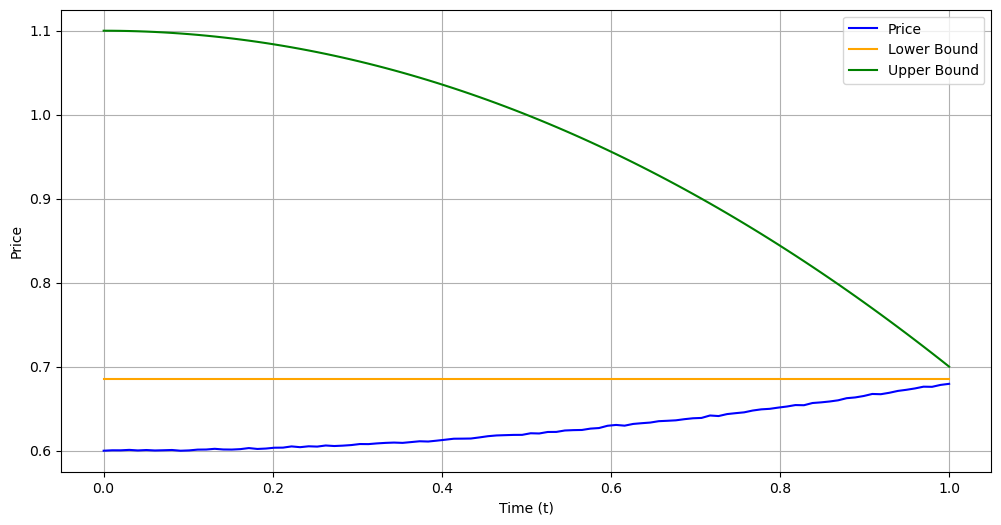

Estimated Option Price: 0.69


In [11]:
option_price = model.estimate_option_price()
print("Estimated Option Price:", option_price)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectories(x, y, cnt, title, ylabel, plot_mean=False):
    plt.figure(figsize=(10, 5))
    for i in range(min(cnt, y.shape[0])):
        plt.plot(x, y[i], alpha=0.5)
    if plot_mean:
        plt.plot(x, np.mean(y, axis=0), color='black', label='Mean', linewidth=2)
    plt.title(title)
    plt.xlabel('Time, $t$')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

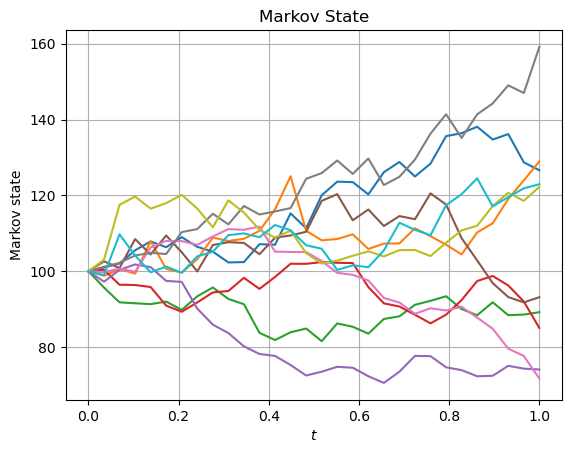

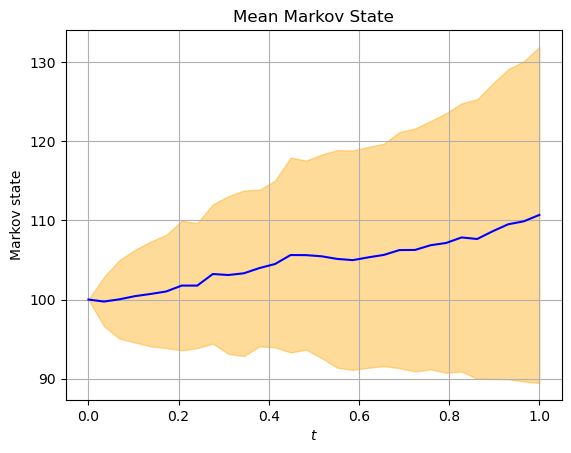

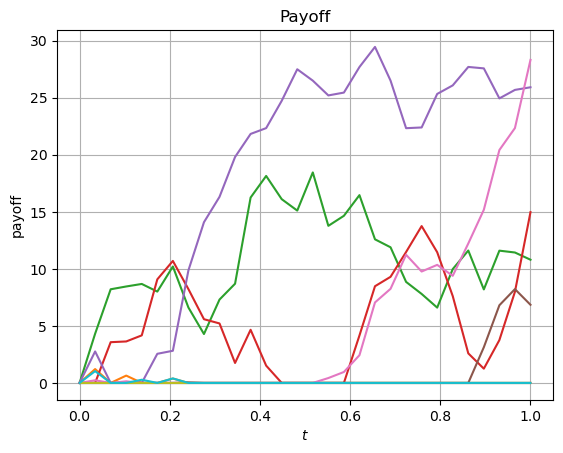

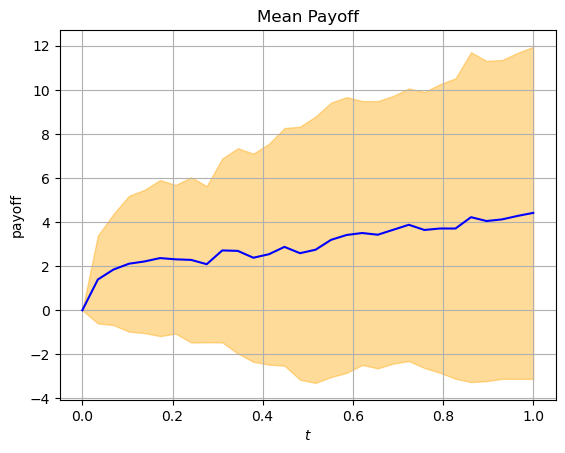

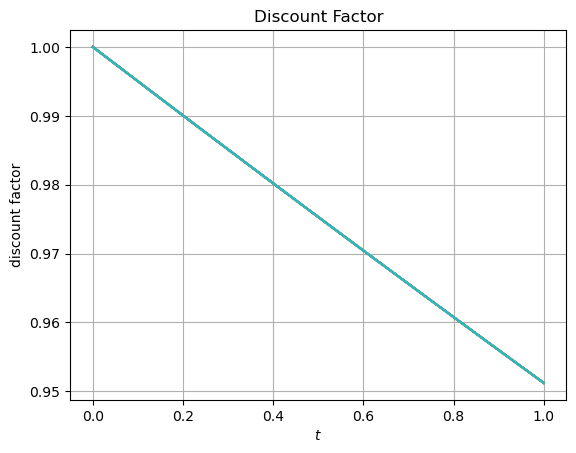

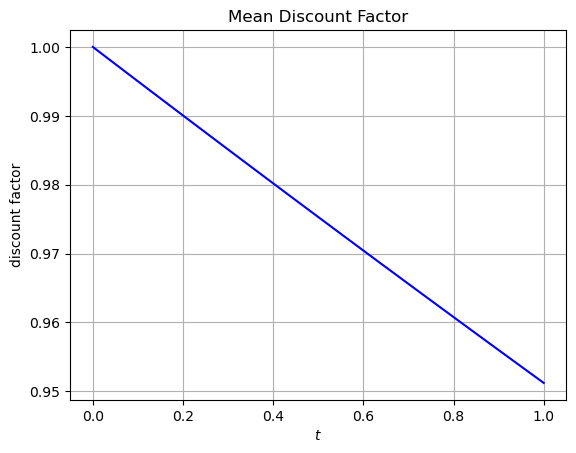

In [13]:
model.sampler.plot(cnt=10, plot_mean=True, y="markov_state")
model.sampler.plot(cnt=10, plot_mean=True, y="payoff, discount_factor")

In [14]:
# class AmericanOptionLSPI:
#     def __init__(self, sampler, num_components=4, gamma=1.0, epsilon=1e-5, iterations=20):
#         self.sampler = sampler
#         self.num_components = num_components  # Adjusted to match the number of available features
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.iterations = iterations
#         self.policy = None
#         self.q_approximation = None
#         self.result = {}
#         self.pca = PCA(n_components=num_components)

#     def feature_functions(self, state, t):
#         """Custom feature functions for state at given time."""
#         M_t = state / self.sampler.strike
#         T_minus_t = self.sampler.t - t

#         return np.array([
#             1,
#             np.exp(-0.5 * M_t),
#             np.exp(-0.5 * M_t) * (1 - M_t),
#             np.exp(-0.5 * M_t) * (1 - 2 * M_t + (M_t ** 2) / 2),
#         ])

#     def _generate_transitions(self):
#         """Simulates the process and generates transitions for LSPI."""
#         self.sampler.sample()
#         raw_features = [self.feature_functions(state, t)
#                         for t in range(self.sampler.cnt_times)
#                         for state in self.sampler.markov_state[:, t, 0]]
        
#         # Fit PCA and transform features
#         transformed_features = self.pca.fit_transform(raw_features)

#         # Generate transitions using PCA-reduced features
#         transitions = []
#         index = 0
#         for i in range(self.sampler.cnt_trajectories):
#             for t in range(self.sampler.cnt_times - 1):
#                 state_features = transformed_features[index]
#                 next_state_features = transformed_features[index + 1]
#                 action = 0  # Continue action
#                 reward = 0  # No reward unless exercised
#                 transitions.append((state_features, action, reward, next_state_features, t))
#                 index += 1
#         return transitions

#     def price(self, test=False, quiet=False):
#         transitions = self._generate_transitions()
#         actions = lambda state: [0, 1]  # Define action space

#         # Convert numpy array state to tuple for use as dictionary key
#         initial_policy = {tuple(state): np.random.choice([0, 1]) for state, _, _, _, _ in transitions}

#         # LSPI Algorithm
#         lspi_generator = least_squares_policy_iteration(
#             transitions=transitions,
#             actions=actions,
#             feature_functions=self.pca.components_.tolist(),  # Ensure components are list of lists
#             initial_target_policy=initial_policy,
#             gamma=self.gamma,
#             epsilon=self.epsilon
#         )

#         for _ in tqdm(range(self.iterations), desc="LSPI Iteration"):
#             self.q_approximation = next(lspi_generator)

#         if not quiet:
#             self._plot_results(plot_mean=True)

#         # Storing results
#         self.result = {"LSPI Policy": self.q_approximation}
#         return self.result

# # Example usage
# sampler = GeometricBrownianMotionPutSampler(
#     cnt_trajectories=10000,
#     cnt_times=30,
#     t=1,
#     time_grid=None,
#     seed=345,
#     sigma=0.2,
#     asset0=100.,
#     strike=100.,
#     mu=0.1
# )

# amc_lspi = AmericanOptionLSPI(sampler)
# result = amc_lspi.price(quiet=False)

In [15]:
# class BasisFunction:
#     def __init__(self, indim, numCenters, outdim):
#         self.indim = indim
#         self.outdim = outdim
#         self.numCenters = numCenters
#         self.centers = [np.random.uniform(-1, 1, indim) for i in xrange(numCenters)]
#         print "Centers",self.centers
#         self.beta = 8
#         self.W = np.random.random((self.numCenters, self.outdim))

#     def _basisfunc(self, c, d):
#         assert len(d) == self.indim
#         norm_1 = (c-d)/((c**2)+(d**2))**(1/2)
#         print (c-d),(norm_1)
#         return np.exp(-self.beta *( (c-d)[0]** 2))

#     # Berechnen de basis FUnction for each sample and gaussion
#     def _calcAct(self, X):
#         # calculate activations of RBFs
#         G = np.zeros((X.shape[0], self.numCenters), float)
#         for ci, c in enumerate(self.centers):
#             for xi, x in enumerate(X):
#                 G[xi, ci] = self._basisfunc(c, x)
#         return G

#     def train(self, X, Y):
#         """ X: matrix of dimensions n x indim
#             y: column vector of dimension n x 1 """

#         # choose random center vectors from training set
#         rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
#         self.centers = [X[i, :] for i in rnd_idx]

#         #print "center", self.centers
#         # calculate activations of RBFs
#         G = self._calcAct(X)
#         #print G


#         # calculate output weights (pseudoinverse)
#         Maximun_likelihood= pinv(G) #pseudoinverse
#         self.W = np.dot(Maximun_likelihood, Y)

#     def test(self, X):
#         """ X: matrix of dimensions n x indim """

#         G = self._calcAct(X)
#         Y = np.dot(G, self.W)
#         return Y



# class Policy:

#     def __init__(self,basis, num_theta, theta=None ):
#         self.basis_function=basis
#         self.actions = [0, 1, 2]

#         self.num_theta=num_theta

#         # uniform distribution of the actions


#         self.theta_behavior= theta

#         if theta is None:
#             self.weights = np.random.uniform(-1.0, 1.0, size=(num_theta,))

#         else:
#             self.weights=theta

#     def set_theta(self, theta):
#         self.weights = (self.weights+theta)*0*5


#     def behavior(self,state,action):
#         prob=0.0
#         if self.theta_behavior is None:
#             self.theta_behavior = np.random.uniform(-1.0, 1.0, size=(self.num_theta,))


#         vector_basis = self.basis_function.evaluate(state, action)
#         return np.dot(vector_basis, self.theta_behavior)




#     def q_value_function(self, state, action ):
#         vector_basis = self.basis_function.evaluate(state,action)
#         return np.dot(vector_basis,self.weights)

#     def get_actions(self, state):


#         q_state_action=[self.q_value_function(state,self.actions[i]) for i in range(len(self.actions))]
#         q_state_action = np.reshape(q_state_action,[len(q_state_action),1])# convert to column vector

#         index = np.argmax(q_state_action)
#         q_max = q_state_action[index]


#         best_actions = [self.actions[index]]
#         ind =[index]

#         for i in range(len(q_state_action)):
#             if q_state_action[i]==q_max and index!=i:
#                 best_actions.append(self.actions[i])
#                 ind.append(i)



#         return best_actions


# """
# important property of LSPI is that it does not require an approximate policy representation,
# At each iteration, a different policy is evaluated
# and certain sets of basis functions may be more appropriate than others for representing
# the state-action value function for each of these policies.

# since LSPI approximates state-action value
# functions, it can use samples from any policy to estimate the state-action value function of
# another policy. This focuses attention more clearly on the issue of exploration since any
# policy can be followed while collecting samples.
# """


# class LSPI:

#     def __init__(self, num_actions=3, num_means=2 ,gamma=0.99 ):

#         print num_actions, num_means

#         self.basis_function = Basis_Function(num_means, num_means, num_actions, gamma)
#         num_basis = self.basis_function._num_basis()

#         self.policy = Policy(self.basis_function, num_basis)
#         self.lstdq  = LSTDQ(self.basis_function, gamma, self.policy)

#         self.stop_criterium= 10**-5
#         self.gamma = gamma



#     #def agent (self,sample,total_iterationen):


#     def _act(self,state):
#         index =  self.policy.get_actions(state)  # TODO: validation for random actions
#         action = self.policy.actions[index[0]]
#         return action



#     def train( self,  sample,  total_iterationen, w_important_Sampling=False  ):

#         error = float('inf')
#         num_interation=0
#         epsilon = 0.001

#         #print "policy weights", self.policy.weights

#         while  (epsilon * (1 - self.gamma) / self.gamma) < error and num_interation< total_iterationen :

#             if w_important_Sampling:
#                 new_weights = self.lstdq.train_weight_parameter ( sample,
#                                                                   self.policy,
#                                                                   self.basis_function )
#             else:
#                 new_weights = self.lstdq.train_parameter(sample,
#                                                          self.policy,
#                                                          self.basis_function)


#             error = np.linalg.norm((new_weights - self.policy.weights))#difference between current policy and target policy
#             self.policy.theta_behavior  = self.policy.weights
#             self.policy.weights = new_weights
#             #print "new weights", self.policy.weights


#             num_interation += 1


#         return self.policy


#     def td_error(self, sample):

#         states = sample[0]
#         actions = sample[1]
#         rewards = sample[2]
#         next_states = sample[3]
#         sample_size = len(states)
#         td_e = 0.0

#         for i in range(sample_size):

#             index = self.policy.get_actions(next_states[i])  # TODO: validation in case more actions
#             action = self.policy.actions[index[0]]

#             index = self.policy.get_actions(states[i])  # TODO: validation in case more actions
#             act = self.policy.actions[index[0]]

#             Vst = self.policy.q_value_function(next_states[i], action)
#             Vs = self.policy.q_value_function(states[i], act)

#             td_e += ((rewards[i] + self.gamma * Vst) - Vs) ** 2
#             # td_e = (rewards[i]- Vs)**2

#         print"td_error=", (td_e / float(sample_size))


#         # return (td_e/sample_size)